In [3]:
import numpy as np
import scipy as sp
from typing import Callable, Type, List
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
from math import sqrt, sin, cos, exp, log, erf
from scipy.special import eval_jacobi
import scipy.misc
from scipy.integrate import quad, quadrature

## Классы для уравнения и граничных условий

In [4]:
@dataclass
class Condition:
    x: float
    y: float

In [5]:
@dataclass
class Equation:
    p: Callable[[float], float]
    q: Callable[[float], float]
    r: Callable[[float], float]
    f: Callable[[float], float]
    condition1: Condition
    condition2: Condition

## Вспомогательные функции

In [6]:
def w_i1(i: int) -> Callable[[float], float]:
    if i >= 2:
        return lambda x: (1 - x ** 2) ** 2 * eval_jacobi(i - 2, 2, 2, x)
    elif i == 0:
        return lambda x: x**2 + 2 * x - 11
    else:
        return lambda x: x**3 - 3 * x + 2

def w_i1_prime(i: int) -> Callable[[float], float]:
    if i >= 2:
        return lambda x: -2 * (i - 1) * (1 - x ** 2) * eval_jacobi(i - 1, 1, 1, x)
    elif i == 0:
        return lambda x: 2 * x + 2
    else:
        return lambda x: 3 * x**2 - 3

def w_i1_second(i: int) -> Callable[[float], float]:
    if i >= 2:
        return lambda x: 4 * (i - 1) * i * eval_jacobi(i, 0, 0, x)
    elif i == 0:
        return lambda x: 2
    else:
        return lambda x: 6 * x

In [22]:
def left_rectangle_method(f, a, b):
    h = (b - a) / 100
    x = np.linspace(a, b, 100)
    return sum([f(x[i]) * h for i in range(0, 99)])

def right_rectangle_method(f, a, b):
    h = (b - a) / 100
    x = np.linspace(a, b, 100)
    return sum([f(x[i]) * h for i in range(1, 100)])

def middle_rectangle_method(f, a, b):
    h = (b - a) / 100
    x = np.linspace(a, b, 100)
    return sum([f((x[i] + x[i - 1]) / 2) * h for i in range(1, 100)])

In [8]:
# TODO: переделать интегрирование с самописными квадратурными формулами
def dot(f, g, a, b):
    integrand = lambda x: f(x) * g(x)
    return sp.integrate.quad(integrand, -1, -1)[0]

In [9]:
def build_coordinate_system(n):
    cs = [(w_i1(i), w_i1_prime(i), w_i1_second(i)) for i in range(2, n + 1)]
    cs.insert(0, (lambda x: x**3 - 3 * x + 2, lambda x: 3 * x**2 - 3, lambda x: 6 * x))
    cs.insert(0, (lambda x: x**2 + 2 * x - 11, lambda x: 2 * x + 2, lambda x: 2))
    return cs

## Метод Галёркина

In [18]:
def Galerkin_method(equation: Type[Equation], 
                   a: float, 
                   b: float, 
                   n: int,
                   integration_method=None) -> Callable[[float], float]:
    definite_integral = lambda f, a, b: quad(f, a, b)[0]
    if integration_method is not None:
        if integration_method == 'middle':
            definite_integral = lambda f, a, b: middle_rectangle_method(f, a, b)
        elif integration_method == 'left':
            definite_integral = lambda f, a, b: left_rectangle_method(f, a, b)
        elif integration_method == 'right':
            definite_integral = lambda f, a, b: right_rectangle_method(f, a, b)
    coord_system = build_coordinate_system(n)
    A = np.zeros((n, n))
    d = np.zeros(n)
    for i in range(n):
        for j in range(n):
            A[i, j] = definite_integral(
                lambda x: coord_system[i][0](x)
                * (
                    equation.p(x) * coord_system[j][2](x)
                    + equation.q(x) * coord_system[j][1](x)
                    + equation.r(x) * coord_system[j][0](x)
                ),
                -1,
                1,
            )
        d[i] = definite_integral(lambda x: equation.f(x) * coord_system[i][0](x), a, b)

    sln = np.linalg.solve(A, d)

    return lambda x: sum(sln[i] * coord_system[i][0](x) for i in range(sln.shape[0]))

## Метод коллокации

In [12]:
def collocation_method(equation, collocation_points, a, b, n):
    cs = build_coordinate_system(n)
    A = np.zeros((n, n))
    d = np.zeros(n)
    
    for i in range(n):
        for j in range(n):
            x = collocation_points[i]
            A[i, j] = (
                equation.p(x) * cs[j][2](x)
                + equation.q(x) * cs[j][1](x)
                + equation.r(x) * cs[j][0](x)
            )
        d[i] = equation.f(collocation_points[i])
    
    c = np.linalg.solve(A, d)
    return lambda x: sum([c[i] * cs[i][0](x) for i in range(c.shape[0])])

## Метод сеток

In [13]:
def network_method(equation, a, b, n0, epsilon, max_iterations):
    alpha = equation.condition1.y
    beta = equation.condition2.y
    r = 2
    p = 1
    
    def error(v1, v2):
        delta = np.zeros(v2.shape[0])
        for i in range(0, v2.shape[0], 2):
            delta[i] = (v2[i] - v1[i // 2]) / (r ** p - 1)
        for i in range(1, v2.shape[0], 2):
            delta[i] = (delta[i - 1] + delta[i + 1]) / 2
        return delta
    
    def error_norm(v1, v2):
        return np.linalg.norm(error(v1, v2)) / sqrt(v2.shape[0])
    
    def clarificate(v1, v2):
        return v2 + error(v1, v2)
    
    def step(n_prev, v_prev, num_iteration):
        n = n_prev * 2
        h = (b - a) / n
        x = np.linspace(a, b, n)
        A = np.zeros((n + 1, n + 1))
        f = np.zeros(n + 1)
        A[0, 0] = 1
        A[n, n] = 1
        f[0] = alpha
        f[n] = beta
        for i in range(1, n):
            A[i, i + 1] = equation.p(x[i]) / (h ** 2) + equation.q(x[i]) / (2 * h)
            A[i, i] = -2 * equation.p(x[i]) / (h ** 2) - equation.r(x[i])
            A[i, i - 1] = equation.p(x[i]) / (h ** 2) - equation.q(x[i]) / (2 * h)
            f[i] = equation.f(x[i])
        v_current = np.linalg.solve(A, f)
        diff = error_norm(v_prev, v_current)
        if diff < epsilon or num_iteration == max_iterations:
            return clarificate(v_prev, v_current)
        else:
            return step(n, v_current, num_iteration + 1)
    
    v0 = np.zeros(n0 + 1)
    solution = step(n0, v0, 1)
    return solution

## Построение графиков


In [14]:
def plot(equation, a, b, N, start_from=2, expected=None):
    fix, ax = plt.subplots(1, 2, figsize=(20, 10), dpi=80)
    
    network_solution = network_method(equation, a, b, 10, 1e-6, 10)
    
    g = np.linspace(a, b, network_solution.shape[0])
    solutions_ax = ax[0]
    solutions_ax.title.set_text('Найденные решения дифура для различных N')
    solutions_ax.set_xlabel('x', fontsize=20)
    solutions_ax.set_ylabel('y', fontsize=20)
    for n in range(start_from, N + 1):
        actual = Galerkin_method(equation, a, b, n)
        solutions_ax.plot(g, actual(g), label=f'N={n}')
    solutions_ax.legend(prop={'size': 13})

    expected_ax = ax[1]
    if expected != None:
        expected = np.vectorize(expected)
        expected_ax.plot(g, expected(g), label=f'Точное решение')
    expected_ax.title.set_text(f'Сравнение результатов метода сеток и проекционных методов')
    expected_ax.set_xlabel('x', fontsize=20)
    expected_ax.set_ylabel('y', fontsize=20)
    expected_ax.plot(g, actual(g), label=f'Решение для N={N}')
    
    collocation = collocation_method(equation, np.linspace(a, b, N), a, b, N)
    collocation = np.vectorize(collocation)
    expected_ax.plot(g, collocation(g), label='Решение методом коллокации')
    
    expected_ax.plot(g, network_solution, label='Решение методом сеток')
    
    expected_ax.legend(prop={'size': 13})

## Тесты

In [15]:
def test1():
    # u'' = 1
    p = lambda x: 1
    q = lambda x: 0
    r = lambda x: 0
    f = lambda x: 1
    condition1 = Condition(-1, 0)
    condition2 = Condition(1, 0)
    equation = Equation(p, q, r, f, condition1, condition2)
    u = lambda x: 5 * x ** 2 + x
    plot(equation, -1, 1, 5, 2, u)
    
def test2():
    # 1 / (x - 3) u'' - xu' + log(2 + x)u = 1 - x/2
    p = lambda x: 1 / (x - 3)
    q = lambda x: -x
    r = lambda x: log(2 + x)
    f = lambda x: 1 - x / 2
    condition1 = Condition(-1, 0)
    condition2 = Condition(1, 0)
    equation = Equation(p, q, r, f, condition1, condition2)
    plot(equation, -1, 1, 10, 5)
    
def test3():
    # u'' - u = 0
    # u(x) = c1 * exp(x) + c2 * exp(-x)
    p = lambda x: 1 / (x - 3)
    q = lambda x: 1 + x / 2
    r = lambda x: -exp(x / 2)
    f = lambda x: 2 - x
    condition1 = Condition(-1, 0)
    condition2 = Condition(1, 0)
    equation = Equation(p, q, r, f, condition1, condition2)
    plot(equation, -1, 1, 10, 5)
    
def test4():
    p = lambda x: 1
    q = lambda x: x
    r = lambda x: 0
    f = lambda x: -2 * x
    condition1 = Condition(-1, 0)
    condition2 = Condition(1, 0)
    u = lambda x: -2 * x + 2 * erf(x / sqrt(2)) / erf(1 / sqrt(2))
    equation = Equation(p, q, r, f, condition1, condition2)
    plot(equation, -1, 1, 10, 5, u)

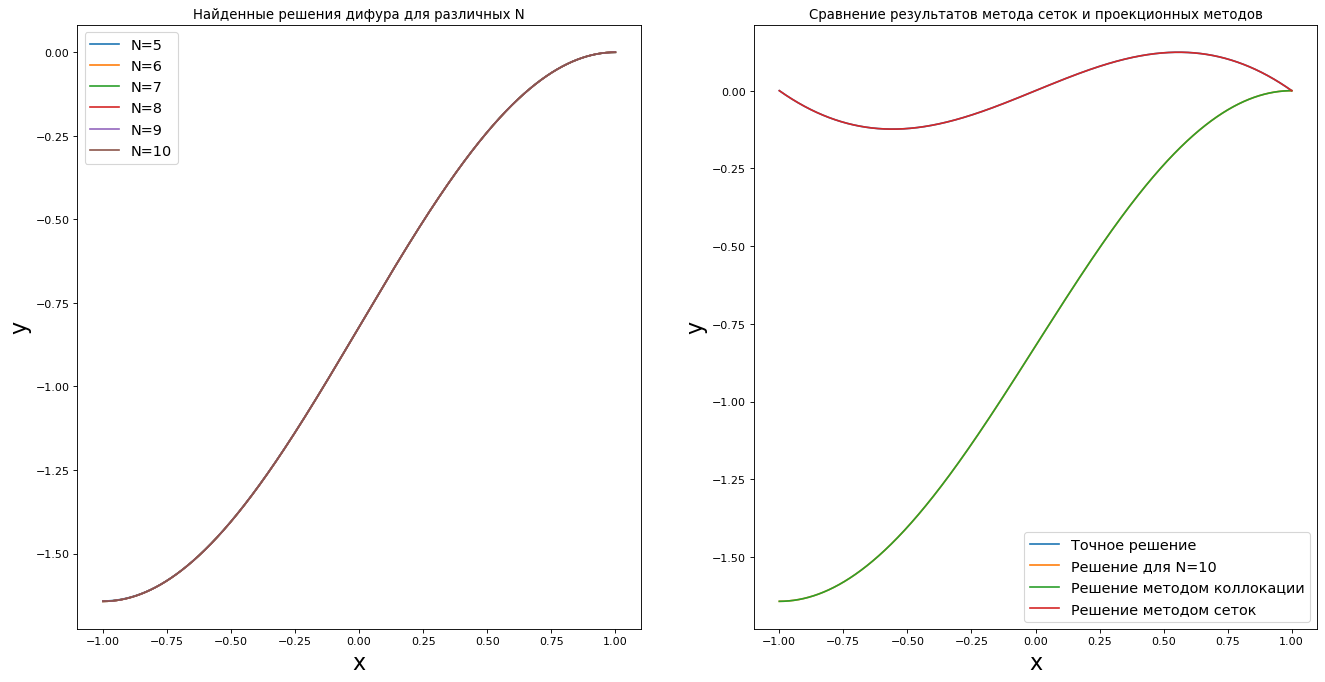

In [19]:
test4()

## Сравнение разных квадратурных формул

In [31]:
def quad_compare():
    p = lambda x: 1
    q = lambda x: x
    r = lambda x: 0
    f = lambda x: -2 * x
    condition1 = Condition(-1, 0)
    condition2 = Condition(1, 0)
    u = lambda x: -2 * x + 2 * erf(x / sqrt(2)) / erf(1 / sqrt(2))
    equation = Equation(p, q, r, f, condition1, condition2)
    g = np.linspace(-1, 1, 1000)
    fix, ax = plt.subplots(1, 2, figsize=(20, 10), dpi=80)
    actual_left = np.vectorize(Galerkin_method(equation, -1, 1, 10, 'left'))
    actual_right = np.vectorize(Galerkin_method(equation, -1, 1, 10, 'right'))
    actual_middle = np.vectorize(Galerkin_method(equation, -1, 1, 10, 'middle'))
    expected_ax = ax[1]
    expected_ax.title.set_text(f'Сравнение результатов метода Галёркина при использовании разных квадратурных формул')
    expected_ax.set_xlabel('x', fontsize=20)
    expected_ax.set_ylabel('y', fontsize=20)
    expected_ax.plot(g, actual_left(g), label='left')
    expected_ax.plot(g, actual_right(g), label='right')
    expected_ax.plot(g, actual_middle(g), label='middle')
    expected_ax.legend(prop={'size': 13})

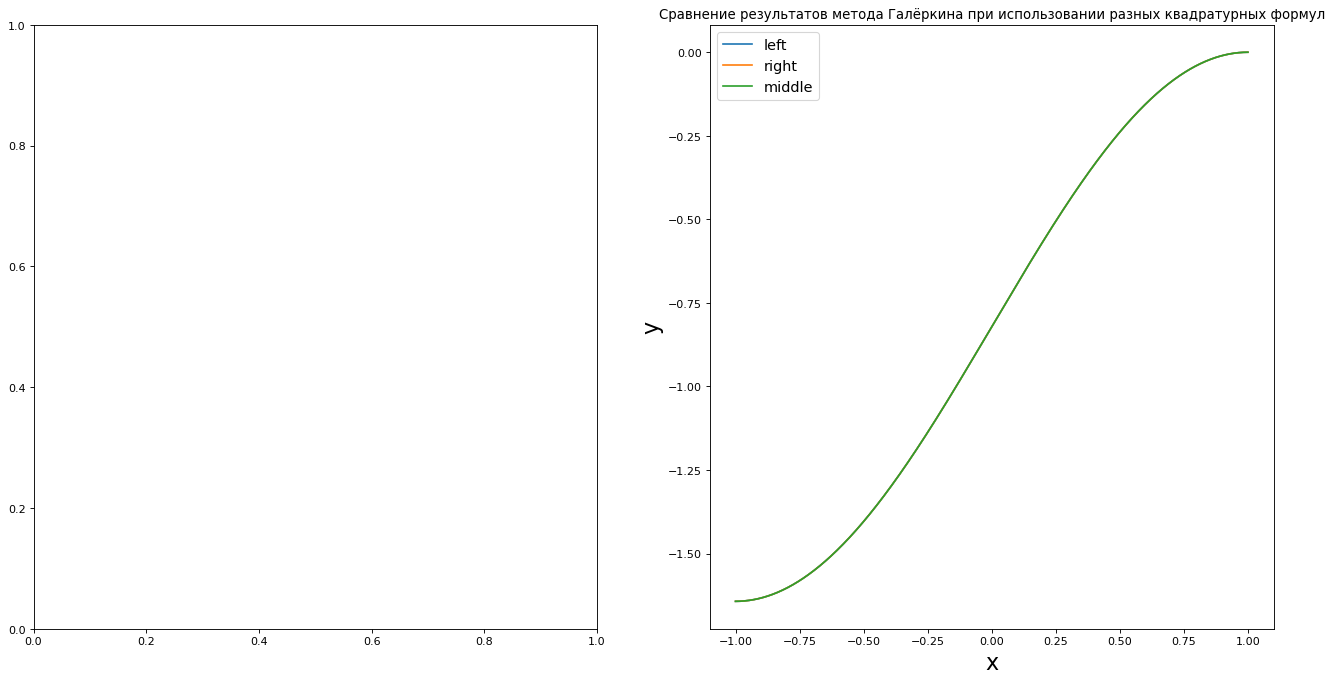

In [32]:
quad_compare()